<a href="https://colab.research.google.com/github/mykolesiko/advanced_RL/blob/master/tic_tac_toe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

In [ ]:

N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        #b xtprint(self.board.shape)
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [ ]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [ ]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

#**Часть первая: крестики-нолики при помощи Q-обучения**

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.  

1.   Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3
2.   Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5


**Disclaimer**: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.  



In [ ]:
#класс стратегии
class Policy:
  def __init__(self):
    self.Q = dict()
    
  def set_learning_params(self, gamma, alpha, eps):
    self.gamma = gamma
    self.alpha = alpha
    self.eps = eps
    
  # eps жадная стратегия    
  def eps_gready(self, board_hash, n_empty):
      #print(n_empty)
      if board_hash in self.Q and np.random.random() > self.eps: # exploitation 
          index = np.argmax(self.Q[board_hash])
      else:
          index = np.random.randint(n_empty) # exploration
          if board_hash not in self.Q: # добавляем состояние
                self.Q[board_hash] = np.zeros(n_empty)
      return index

  def gready(self, board_hash, n_empty):
      if board_hash in self.Q:  
          index = np.argmax(self.Q[board_hash])
      else:
          index = np.random.randint(n_empty) 
      return index 

  def updateQ(self, prev_board_hash, current_board_hash, prev_action, reward):     
     if prev_board_hash is not None:
          temp = self.gamma * np.max(self.Q[current_board_hash]) if current_board_hash in self.Q else 0
          self.Q[prev_board_hash][prev_action] += self.alpha * (-abs(reward) + temp - self.Q[prev_board_hash][prev_action])           

  def set_Q(self, board_hash, index, reward):                
     self.Q[board_hash][index] = reward
     


In [ ]:
import random
import math

class Learner_by_games:
   def __init__(self, env, pi1, pi2):
    self.env = env
    self.pi = (pi1, pi2)
    #self.alpha = alpha
    #self.eps = eps
    #self.gamma = gamma

   def step(self, pi1, pi2, prev_board_hash_1, prev_action_1, prev_board_hash_2, prev_action_2, board_hash, emptySpaces, curTurn):
        n_epmty = len(emptySpaces)
        #print(board_hash, n_epmty)
        if pi1 is not None:
            index = pi1.eps_gready(board_hash, n_epmty)
        else: #играем со случайно стратегией
            index = np.random.randint(n_empty) # exploration   
        #print(index)    
        action = emptySpaces[index]
        #print(action)
        state, reward, done, _ = env.step(action)
        board_hash_new, emptySpaces_new, curTurn_new = state
        pi2.updateQ(prev_board_hash_2, board_hash_new, prev_action_2, reward) 
        if (reward == 1) or (reward == -1):
            pi1.set_Q(board_hash, index, abs(reward))
        prev_board_hash_1 = board_hash
        prev_action_1 = index
        board_hash, emptySpaces, curTurn = board_hash_new, emptySpaces_new, curTurn_new
        return prev_board_hash_1, prev_action_1, board_hash, emptySpaces, curTurn, done


   def game_learn(self):
        env.reset()
        board_hash, emptySpaces, curTurn = env.getState()
        reward = 0
        done = False
        prev_board_hash = [None, None]
        prev_action = [None, None]
        while not done:
          if curTurn == 1:
              index1 = 0
              index2 = 1
          else:
              index1 = 1
              index2 = 0
          prev_board_hash[index1], prev_action[index1], board_hash, emptySpaces, curTurn, done = self.step(self.pi[index1], self.pi[index2], prev_board_hash[index1], prev_action[index1], prev_board_hash[index2], prev_action[index2], board_hash, emptySpaces, curTurn)
          
   def game_no_learn (self, pi1, pi2):
       env.reset()
       board_hash, emptySpaces, curTurn = env.getState()
       reward = 0
       done = False
       
       while not done:
         if curTurn == 1:
              pi = pi1
         else:
              pi = pi2
         n_empty = len(emptySpaces)    
         if pi is not None:
                index = pi.gready(board_hash, n_empty)
         else:
                index = np.random.randint(n_empty)
         action = emptySpaces[index]
         state, reward, done, _ = env.step(action)
         board_hash, emptySpaces, curTurn = state
       return reward


   def get_policy_reward(self, pi1=None, pi2=None, num_episodes=500):
        total_reward = 0
        for _ in range(num_episodes):
            total_reward += self.game_no_learn(pi1, pi2)
        return total_reward / num_episodes

   def plot_policy_reward(self, epochs, crosses, zeros):
      plt.figure(figsize=(10, 5))
      plt.xlabel('Number of epochs')
      plt.ylabel('Reward for policy')
      plt.plot(epochs, crosses, label='Crosses')
      plt.plot(epochs, zeros, label='Zeros')
      plt.legend(loc="upper left")


100%|██████████| 200000/200000 [04:53<00:00, 680.35it/s] 


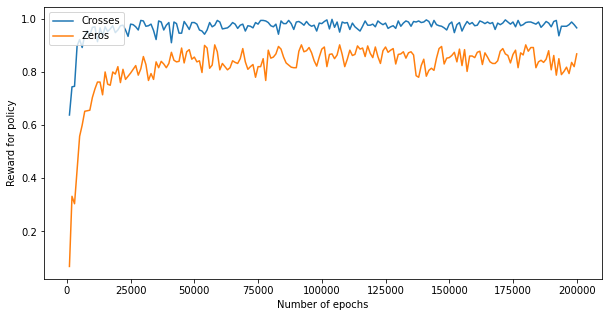

In [ ]:
alpha=0.009
epsilon=0.3
gamma=1.0

pi1_3x3 = Policy()
pi1_3x3.set_learning_params(alpha, epsilon, gamma)
pi2_3x3 = Policy()
pi2_3x3.set_learning_params(alpha, epsilon, gamma)

env = TicTacToe(3, 3, 3)
learner = Learner_by_games(env, pi1_3x3, pi2_3x3)
total_episodes = 200000
test_episodes = 1000
epochs = []
crosses = []
zeros = []

for i in tqdm.tqdm(range(1, total_episodes + 1)):
    learner.game_learn()
    if i % test_episodes == 0:
        reward = learner.get_policy_reward(pi1_3x3, None, num_episodes=500)
        crosses.append(reward)
        reward = -learner.get_policy_reward(None, pi2_3x3, num_episodes=500)
        zeros.append(reward)
        epochs.append(i)
        
learner.plot_policy_reward(epochs, crosses, zeros)

100%|██████████| 2000000/2000000 [1:47:34<00:00, 309.87it/s]


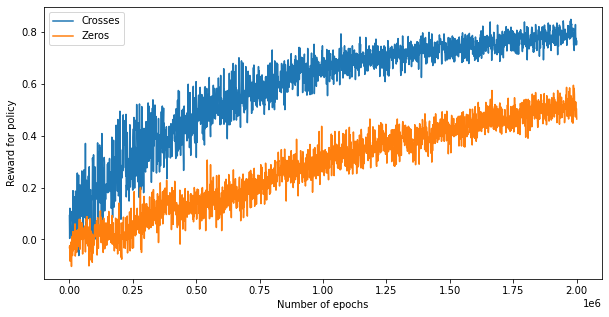

In [ ]:
alpha=0.009
eps=0.3
gamma=1.0

pi1 = Policy()
pi1.set_learning_params(alpha, eps, gamma)
pi2 = Policy()
pi2.set_learning_params(alpha, eps, gamma)

env = TicTacToe(4, 4, 4)
learner = Learner_by_games(env, pi1, pi2)
total_episodes = 2000000
test_episodes = 1000
epochs = []
crosses = []
zeros = []

for i in tqdm.tqdm(range(1, total_episodes + 1)):
    learner.game_learn()
    if i % test_episodes == 0:
        reward = learner.get_policy_reward(pi1, None, num_episodes=500)
        crosses.append(reward)
        reward = -learner.get_policy_reward(None, pi2, num_episodes=500)
        zeros.append(reward)
        epochs.append(i)
        
learner.plot_policy_reward(epochs, crosses, zeros)

#Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).


1.   Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
2.  Реализуйте Double DQN и/или Dueling DQN.





In [ ]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [ ]:
class NN_Q(nn.Module):
    def __init__(self, channels_in, channels_out, kernels, linear_in, linear_out):
       nn.Module.__init__(self)
       self.convs = nn.ModuleList([nn.Conv2d(channels_in[i], channels_out[i], kernel_size = kernels[i], stride=1) for i in range(len(channels_in))])
       self.fcs = nn.ModuleList([nn.Linear(linear_in[i], linear_out[i]) for i in range(len(linear_in))]) 
       self.flat = nn.Flatten(1, 3)
    def forward(self, input):
       output = input
       for i, conv in enumerate(self.convs):
           output = conv(output)
           output = F.relu(output)
       output = self.flat(output)   
       for i, fc in enumerate(self.fcs):
           output = fc(output)
           if i != (len(linear_in) - 1):
                output = F.relu(output)
       
       return output




In [ ]:
MEMORY_SIZE = 1000000
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')


class DQN():
        def __init__(self, models, n_rows = 4, n_cols= 4, n_win = 4,  gamma = 0.8, lr = 0.0001, weight_decay = 0.001, batch_size = 512, device=device):
        #def __init__(self, models, n_rows = 4, n_cols= 4, n_win = 4,  gamma = 0.9, lr = 0.0001, weight_decay = 0.001, batch_size = 512, device=device):
            #print(n_rows)
            self.env = TicTacToe(n_rows, n_cols, n_win)
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.device = device
            self.models = {-1: models[0].to(device), 1: models[1].to(device)}
            self.memories = {-1: ReplayMemory(MEMORY_SIZE), 1: ReplayMemory(MEMORY_SIZE)}
            self.optimizers = {-1: optim.Adam(self.models[-1].parameters(), lr=lr, weight_decay=weight_decay),
                                1: optim.Adam(self.models[1].parameters(), lr=lr, weight_decay=weight_decay)}
            self.prev_state = {-1: None, 1: None}
            self.prev_action = {}
            self.steps_done = 0
            self.gamma = gamma
            self.batch_size = batch_size
                
            self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 100000
            self.num_step = 0


        def state_to_tensor(self, state):
              state_int = np.array([int(char) for char in state])
              n = self.n_rows
              crosses = np.where(state_int==2, 1, 0).reshape(n, n)
              zeros = np.where(state_int==0, 1, 0).reshape(n, n)
              emptySpaces = np.where(state_int==1, 1, 0).reshape(n, n)
              return torch.Tensor(np.stack([crosses, zeros, emptySpaces])).reshape(3, n, n)



        def select_greedy_action(self, state, cur_turn):
               return self.models[cur_turn](state.unsqueeze(0)).data.max(1)[1].view(1, 1)

        def select_action(self, state, cur_turn):
              sample = random.random()
              self.num_step += 1
              eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
              if sample > eps_threshold:
                  return self.select_greedy_action(state, cur_turn)
              else:
                  return torch.tensor([[random.randrange(self.n_rows * self.n_cols)]], dtype=torch.int64)
     

        def run_episode(self,  e=0, do_learning=True, greedy=False, render=False):
          self.env.reset()
          done = False
          self.prev_state = {-1: None, 1: None}
          self.prev_action = {}
          state, self.emptySpaces, cur_turn = self.env.getState()
          while not done:
              state_tensor = self.state_to_tensor(state)
              with torch.no_grad():
                  if greedy:
                      index = self.select_greedy_action(state_tensor.to(self.device), cur_turn).cpu()
                  else:
                      index = self.select_action(state_tensor.to(self.device), cur_turn).cpu()
                                         
              self.prev_state[cur_turn]  = state_tensor
              self.prev_action[cur_turn]  = index
              action = self.env.action_from_int(index.numpy()[0][0])
              #print(index, action)
              (next_state, emptySpaces, next_cur_turn), reward, done, _ = self.env.step(action)
              next_state_tensor = self.state_to_tensor(next_state)
              
              if done == True:
                if reward == -10:
                      transition = (state_tensor, index, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                      self.memories[cur_turn].store(transition)
                      # transition = (self.prev_state[next_cur_turn], self.prev_action[next_cur_turn], next_state_tensor, torch.tensor([1.0], dtype=torch.float32))
                      # self.memories[next_cur_turn].store(transition)  
                else:
                      transition = (state_tensor, index, next_state_tensor, torch.tensor([abs(reward)], dtype=torch.float32))
                      self.memories[cur_turn].store(transition)
                      transition = (self.prev_state[next_cur_turn], self.prev_action[next_cur_turn], next_state_tensor, torch.tensor([next_cur_turn * reward], dtype=torch.float32))
                      self.memories[next_cur_turn].store(transition)  
              else:
                if self.prev_state[next_cur_turn] is not None:
                      transition = (self.prev_state[next_cur_turn], self.prev_action[next_cur_turn], next_state_tensor, torch.tensor([reward * next_cur_turn], dtype=torch.float32))
                      self.memories[next_cur_turn].store(transition)  

              if do_learning:
                    self.learn(next_cur_turn)

              state = next_state
              cur_turn = next_cur_turn

   
        def learn(self, cur_turn):
                  if np.min([len(self.memories[cur_turn]), len(self.memories[-cur_turn])]) < self.batch_size:
                      return
                  
                  # берём мини-батч из памяти
                  transitions = self.memories[cur_turn].sample(self.batch_size)
                  batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

                  batch_state = Variable(torch.stack(batch_state).to(self.device))
                  batch_action = Variable(torch.cat(batch_action).to(self.device))
                  batch_reward = Variable(torch.cat(batch_reward).to(self.device))
                  batch_next_state = Variable(torch.stack(batch_next_state).to(self.device))
                  
                  # считаем значения функции Q
                  Q = self.models[cur_turn](batch_state)
                  Q = Q.gather(1, batch_action).reshape([self.batch_size])
                  
                  # оцениваем ожидаемые значения после этого действия
                  Qmax = self.models[cur_turn](batch_next_state).detach()
                  Qmax = Qmax.max(1)[0]
                  Qnext = batch_reward + (self.gamma * Qmax)
                  # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
                  loss = F.smooth_l1_loss(Q, Qnext)
                  # if self.num_step % 1000 == 0:
                  #       print(loss.item())
        
                  self.optimizers[cur_turn].zero_grad()
                  loss.backward()
                  
                  self.optimizers[cur_turn].step()

    
        def get_policy_reward(self, player, n_episodes=1000):
                rewards = []
                for _ in range(n_episodes):
                    self.env.reset()
                    state, empty_spaces, cur_turn = self.env.getState()
                    done = False
                    while not done:
                        if cur_turn == player:
                            idx = self.select_greedy_action(self.state_to_tensor(state).to(device), player)
                            action = self.env.action_from_int(idx)
                        else:
                            idx = np.random.randint(len(empty_spaces))
                            action = empty_spaces[idx]
                        (state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
                    if reward != -10:
                        rewards.append(reward * player)
                    else:
                        if cur_turn == player:
                            rewards.append(reward)
                    #print(reward)        
                return np.array(rewards)



In [ ]:
def learn(learner, epochs, n_episodes, period):
      crosses_win = []
      zeros_win = [] 
      
      for i in tqdm.tqdm(range(1, epochs + 1)):
            learner.run_episode(do_learning=True)
            if i % period == 0:
                crosses = learner.get_policy_reward(1, n_episodes)
                zeros = learner.get_policy_reward(-1, n_episodes)
                crosses_win.append(np.sum(crosses==1)/n_episodes)
                zeros_win.append(np.sum(zeros==1)/n_episodes)
      return (crosses_win, zeros_win)        
         

In [ ]:
def show_results(crosses, zeros):
    plt.figure(figsize=(10, 6))
    plt.plot(crosses, label='crosses')
    plt.plot(zeros, label='zeros')
    #plt.xlabel(f'{period} эпизодов')
    #plt.ylabel('Процент исходов')
    plt.legend(loc='lower left')

100%|██████████| 50000/50000 [24:29<00:00, 34.02it/s]


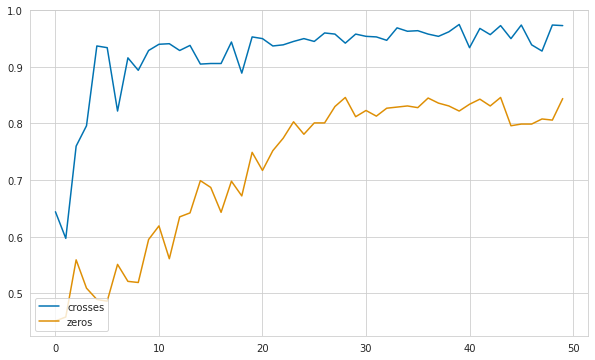

In [ ]:
channels_in = [3]
channels_out = [128]
kernels = [3]
linear_in = [128, 64]
linear_out = [64, 9]

nn_zeros = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
learner_3x3 = DQN([nn_zeros, nn_crosses], 3, 3, 3)
crosses, zeros = learn(learner_3x3, 50000, 1000, 1000)
show_results(crosses, zeros)

100%|██████████| 30000/30000 [27:14<00:00, 18.35it/s]


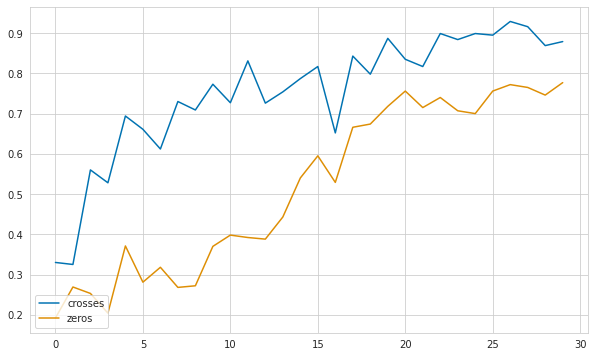

In [ ]:
channels_in = [3, 128 ]
channels_out = [128, 256]
kernels = [3, 2]
linear_in = [256, 128]
linear_out = [128, 16]

nn_zeros = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
learner_4x4 = DQN([nn_zeros, nn_crosses], 4, 4, 4)
crosses, zeros = learn(learner_4x4, 30000, 1000, 1000)
show_results(crosses, zeros)

In [ ]:
class DoubleDQN(DQN):
  def __init__(self, models, target_models, n_rows=4, n_cols=4, n_win=4,  gamma=0.8, device=device, tau = 0.01 ):
    #super( DoubleDQN, self).__init__(models, n_rows=n_rows, n_cols = n_cols, n_win = n_win,  gamma=gamma, device=device)
    super().__init__(models, n_rows, n_cols, n_win,  gamma=gamma, device=device)
    self.target_models = {-1: target_models[0].to(device), 1: target_models[1].to(device)}
    self.tau = tau
    #print(self.env.board.shape)
    #super().__init__(self)#models, 4, 4, 4,  gamma=gamma, device=device)



    def learn(self, cur_turn):
                  if np.min([len(self.memories[cur_turn]), len(self.memories[-cur_turn])]) < self.batch_size:
                      return
                  
                  # берём мини-батч из памяти
                  transitions = self.memories[cur_turn].sample(self.batch_size)
                  batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

                  batch_state = (torch.stack(batch_state).to(self.device))
                  batch_action = (torch.cat(batch_action).to(self.device))
                  batch_reward = (torch.cat(batch_reward).to(self.device))
                  batch_next_state = (torch.stack(batch_next_state).to(self.device))
                  
                  # считаем значения функции Q
                  Q = self.models[cur_turn](batch_state)
                  Q = Q.gather(1, batch_action).reshape([self.batch_size])
                  
                  # оцениваем ожидаемые значения после этого действия
                  Qmax = self.target_models[cur_turn](batch_next_state).detach()
                  Qmax = Qmax.max(1)[0]
                  Qnext = batch_reward + (self.gamma * Qmax)
                  # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
                  loss = F.smooth_l1_loss(Q, Qnext)
                  # if self.num_step % 1000 == 0:
                  #       print(loss.item())
        
                  self.optimizers[cur_turn].zero_grad()
                  loss.backward()
                  
                  self.optimizers[cur_turn].step()  
                  for target_param, param in zip(self.target_models[cur_turn].parameters(), self.models[cur_turn].parameters()):
                        target_param.data.copy_(self.tau * param + (1 - self.tau) * target_param)



100%|██████████| 30000/30000 [14:28<00:00, 34.56it/s]


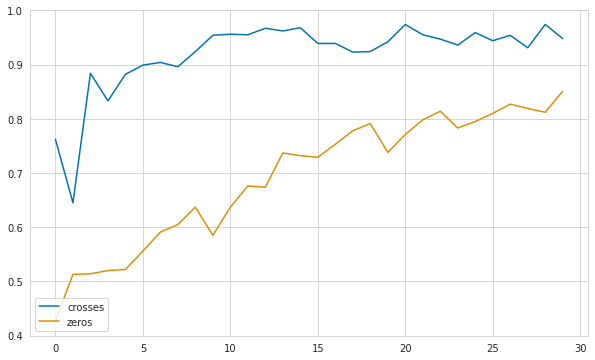

In [ ]:
channels_in = [3]
channels_out = [128]
kernels = [3]
linear_in = [128, 64]
linear_out = [64, 9]

nn_zeros = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
nn_zeros_target = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses_target = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
double_learner_3x3 = DoubleDQN([nn_zeros, nn_crosses], [nn_zeros_target, nn_crosses_target], 3, 3, 3)
crosses, zeros = learn(double_learner_3x3, 30000, 1000, 1000)
show_results(crosses, zeros)

100%|██████████| 100000/100000 [1:38:11<00:00, 16.97it/s]


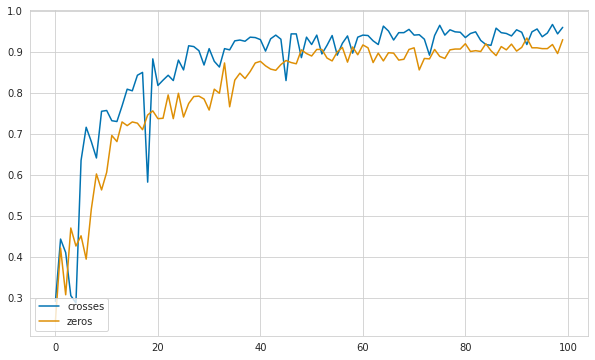

In [ ]:
channels_in = [3, 128 ]
channels_out = [128, 256]
kernels = [3, 2]
linear_in = [256, 128]
linear_out = [128, 16]

nn_zeros = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
nn_zeros_target = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses_target = NN_Q(channels_in, channels_out, kernels, linear_in, linear_out)
double_learner_4x4 = DoubleDQN([nn_zeros, nn_crosses], [nn_zeros_target, nn_crosses_target], 4, 4, 4)
crosses, zeros = learn(double_learner_4x4, 100000, 1000, 1000)
show_results(crosses, zeros)

In [ ]:
class NN_Q_Dueling(nn.Module):
    def __init__(self, channels_in, channels_out, kernels, linear_in, linear_out):
       nn.Module.__init__(self)
       n = len(linear_in)
       self.convs = nn.ModuleList([nn.Conv2d(channels_in[i], channels_out[i], kernel_size = kernels[i], stride=1) for i in range(len(channels_in))])
       self.fcs = nn.ModuleList([nn.Linear(linear_in[i], linear_out[i]) for i in range(n)]) 
       self.fc_v = nn.Linear(linear_in[n - 1], 1)
       self.flat = nn.Flatten(1, 3)
    def forward(self, input):
       output = input
       for i, conv in enumerate(self.convs):
           output = conv(output)
           output = F.relu(output)
       output = self.flat(output)   
       for i, fc in enumerate(self.fcs):
           if i != (len(linear_in) - 1):
                output = fc(output)
                output = F.relu(output)
           else:
             output_v = self.fc_v(output)
             output_a = fc(output)
       output = output_v + (output_a - output_a.mean(dim=1, keepdim=True))      
       return output

100%|██████████| 50000/50000 [51:30<00:00, 16.18it/s]


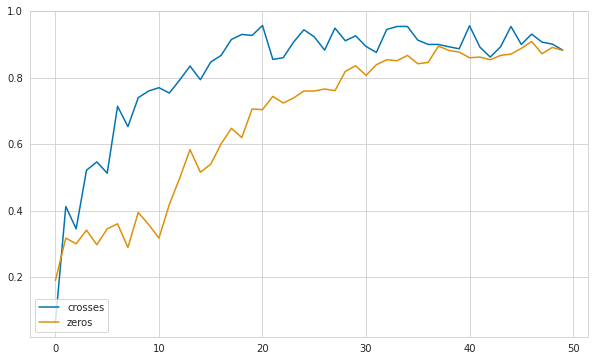

In [ ]:
channels_in = [3, 128 ]
channels_out = [128, 256]
kernels = [3, 2]
linear_in = [256, 128]
linear_out = [128, 16]

nn_zeros = NN_Q_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses = NN_Q_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)
nn_zeros_target = NN_Q_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses_target = NN_Q_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)
dueling_double_learner_4x4 = DoubleDQN([nn_zeros, nn_crosses], [nn_zeros_target,  nn_crosses_target], 4, 4, 4)
crosses, zeros = learn(dueling_double_learner_4x4, 50000, 1000, 1000)
show_results(crosses, zeros)

100%|██████████| 50000/50000 [38:24<00:00, 21.69it/s]


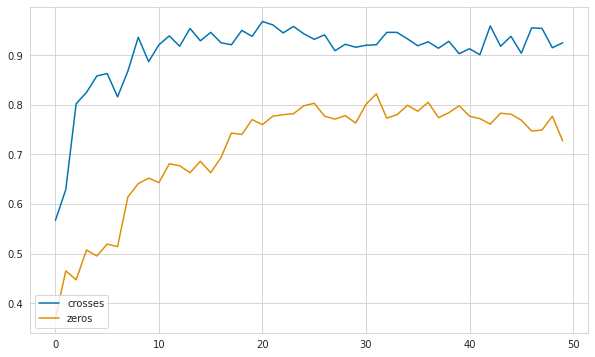

In [ ]:
channels_in = [3]
channels_out = [128]
kernels = [3]
linear_in = [128, 64]
linear_out = [64, 9]

nn_zeros = NN_Q_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses = NN_Q_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)
nn_zeros_target = NN_Q_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses_target = NN_Q_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)
double_dueling_learner_3x3 = DoubleDQN([nn_zeros, nn_crosses], [nn_zeros_target,  nn_crosses_target], 3, 3, 3)
crosses, zeros = learn(double_dueling_learner_3x3, 50000, 1000, 1000)
show_results(crosses, zeros)